## Neural Network

In [227]:
# Import all required libraries
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import mean, std
from keras import activations
from keras.models import Sequential
from keras.layers import Dense
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [228]:
# Import feature and target columns
X = pickle.load(open("./common/feature_status.p", "rb"))
y = pickle.load(open("./common/target_status.p", "rb"))
feature_cols = pickle.load(open("./common/feature_cols.p", "rb"))

### Perform Cross Validation

In [229]:
# Define a sklearn-compatible classifier based on our Keras model
class KerasBinaryClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        self.model.compile(loss='binary_crossentropy', optimizer='adam')
        self.model.fit(X, y, epochs=150, batch_size=10, verbose=0)
        return self
    def predict(self, X):
        Y_pred = self.model.predict(X)
        Y_pred = (Y_pred >= 0.5).astype(int)
        return Y_pred.flatten()

In [230]:
# Function to create the model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Dense(6, input_dim=len(feature_cols), activation=activations.softplus))
    model.add(Dense(6, activation=activations.relu))
    model.add(Dense(6, activation=activations.tanh))
    model.add(Dense(1, activation=activations.sigmoid))
    
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [231]:
clf_cv = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

# Define metrics
scoring = ['precision_macro', 'recall_macro', 'f1_macro']
# scoring = { 'accuracy': make_scorer(accuracy_score),
#             'precision': make_scorer(precision_score),
#             'recall': make_scorer(recall_score),
#             'F1': make_scorer(f1_score) }


# Define the cross-validation procedure
cv = KFold(n_splits=10, shuffle=False)

C:\Users\dell\AppData\Local\Temp\ipykernel_33388\3710175904.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf_cv = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


In [232]:
# scores = cross_validate(clf_cv, X, y, cv=10, scoring=scoring)
scores = cross_validate(clf_cv, X, y, scoring=scoring, cv=cv, n_jobs=-1)

In [233]:
# Print scores
# for metric_name, score_array in scores.items():
#     if metric_name.startswith('test_'):
#         print(f'{metric_name}: {score_array.mean():.2f} (+/- {score_array.std() * 2:.2f})')
print('Precision: %.3f (%.3f)' % (mean(scores['test_precision_macro']), std(scores['test_precision_macro'])))
print('Recall: %.3f (%.3f)' % (mean(scores['test_recall_macro']), std(scores['test_recall_macro'])))
print('F1 score: %.3f (%.3f)' % (mean(scores['test_f1_macro']), std(scores['test_f1_macro'])))

Precision: 0.658 (0.281)
Recall: 0.700 (0.245)
F1 score: 0.677 (0.264)


### Train the model

In [8]:
# Import training and testing data
X_test = pickle.load(open("./common/metrics_test.p", "rb"))
X_train = pickle.load(open("./common/metrics_train.p", "rb"))
y_test = pickle.load(open("./common/status_test.p", "rb"))
y_train = pickle.load(open("./common/status_train.p", "rb"))

In [9]:
# Define the model
clf = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

# Train the model
clf.fit(X_train, y_train, epochs=150, batch_size=10, verbose=1)

C:\Users\dell\AppData\Local\Temp\ipykernel_33388\3781437085.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


Epoch 1/150
173/173 [==============================] - 1s 2ms/step - loss: 219.1944
Epoch 2/150
173/173 [==============================] - 0s 2ms/step - loss: 12.2709
Epoch 3/150
173/173 [==============================] - 0s 2ms/step - loss: 11.5012
Epoch 4/150
173/173 [==============================] - 0s 1ms/step - loss: 11.1230
Epoch 5/150
173/173 [==============================] - 0s 1ms/step - loss: 10.8817
Epoch 6/150
173/173 [==============================] - 0s 1ms/step - loss: 10.1395
Epoch 7/150
173/173 [==============================] - 0s 1ms/step - loss: 10.4571
Epoch 8/150
173/173 [==============================] - 0s 2ms/step - loss: 9.2868
Epoch 9/150
173/173 [==============================] - 0s 1ms/step - loss: 9.6391
Epoch 10/150
173/173 [==============================] - 0s 1ms/step - loss: 8.9362
Epoch 11/150
173/173 [==============================] - 0s 2ms/step - loss: 8.1198
Epoch 12/150
173/173 [==============================] - 0s 1ms/step - loss: 7.1495
Epoch

In [10]:
# Use the model to make predictions on the test set
y_pred = clf.predict(X_test)
y_pred = [1 if y >= 0.5 else 0 for y in y_pred]  # threshold

14/14 [==============================] - 0s 2ms/step


In [11]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Accuracy: 0.9561200923787528
Precision: 0.7272727272727273
Recall: 0.7058823529411765
F1: 0.7164179104477613


### Visualize the model

In [12]:
clf_matrix = confusion_matrix(y_test, y_pred)
clf_matrix

array([[390,   9],
       [ 10,  24]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted Label')

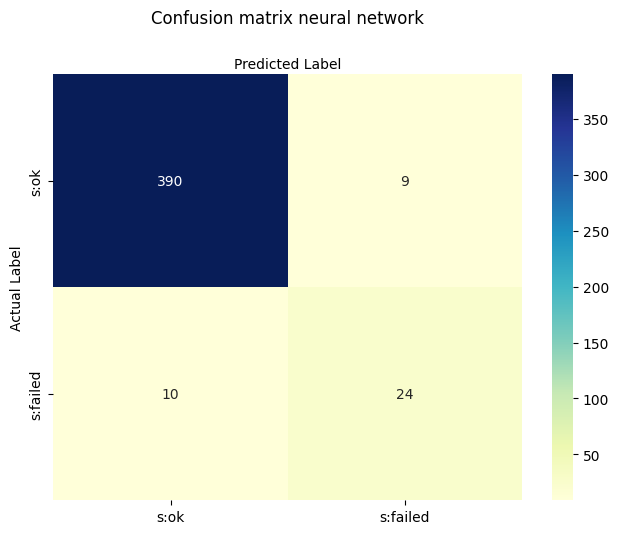

In [13]:
# Assuming clf_matrix is the confusion matrix you've computed
clf_matrix_df = pd.DataFrame(clf_matrix, index=["s:ok", "s:failed"], columns=["s:ok", "s:failed"])

# Create heatmap
class_names=["s:ok", "s:failed"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(clf_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('Confusion matrix neural network', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

### Export the model

In [14]:
pickle.dump(clf, open("./models/neural_network.p", "wb"))